**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_1_)    
  - [Preprocessing](#toc1_2_)    
      - [Standardize](#toc1_2_1_1_)    
      - [Dataset Split](#toc1_2_1_2_)    
    - [Shallow MLP](#toc1_2_2_)    
      - [Params](#toc1_2_2_1_)    
      - [Shallow MLP model](#toc1_2_2_2_)    
      - [Single train](#toc1_2_2_3_)    
      - [Plots](#toc1_2_2_4_)    
      - [Grid search](#toc1_2_2_5_)    
    - [DeepMLP](#toc1_2_3_)    
      - [Model](#toc1_2_3_1_)    
      - [Params](#toc1_2_3_2_)    
      - [Plots](#toc1_2_3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, f1_score
import random

from codecarbon import track_emissions


In [6]:
seed =42
# Set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)
generator = torch.Generator().manual_seed(seed)

## <a id='toc1_2_'></a>[Preprocessing](#toc0_)

In [7]:
df = pd.read_excel('..//HeartFailure.xlsx')
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [8]:
for col in df.columns:
    if df[col].dtypes =='O':
        df[col] = pd.Categorical(df[col]).codes

df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [9]:
print(df['HeartDisease'].value_counts())

1    508
0    410
Name: HeartDisease, dtype: int64


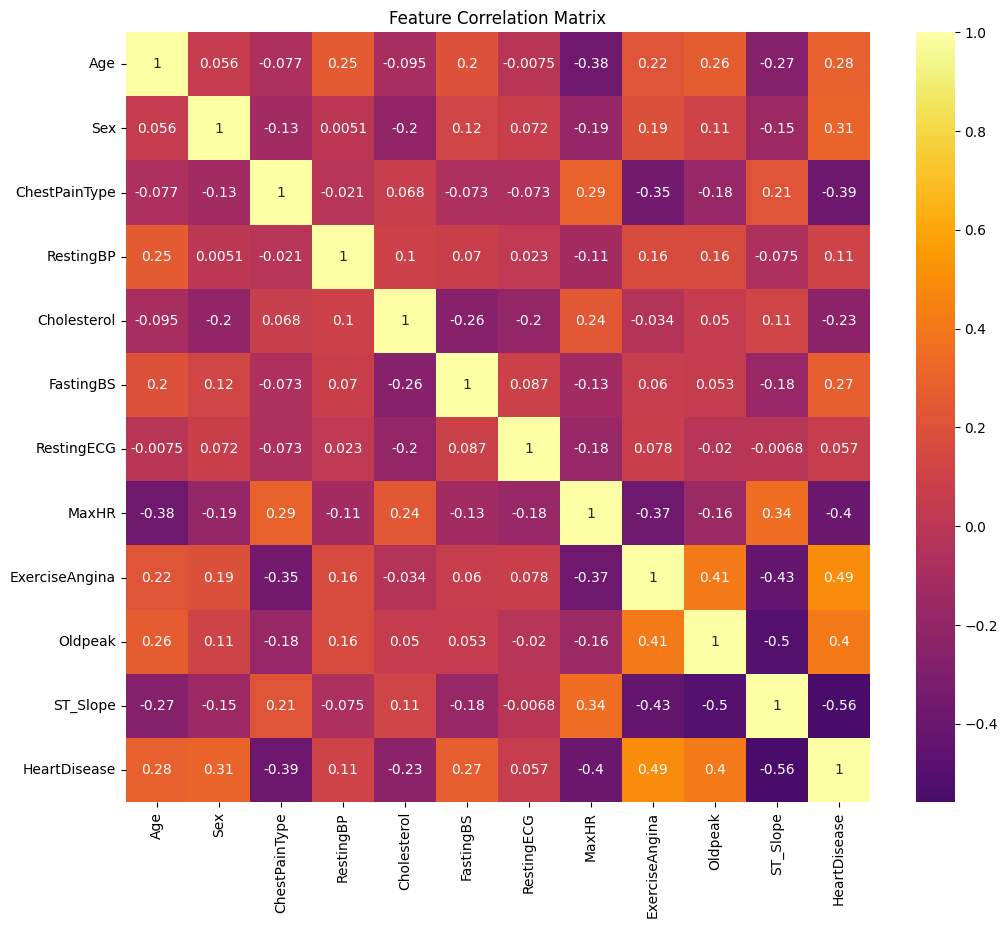

In [10]:
corr_matrix = df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='inferno', center=0)
plt.title('Feature Correlation Matrix')
plt.show()



#### <a id='toc1_2_1_1_'></a>[Standardize](#toc0_)

In [11]:
# Select the columns to be standardized
columns_to_standardize = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

#### <a id='toc1_2_1_2_'></a>[Dataset Split](#toc0_)

In [12]:
#Split the dataset into training and testing sets
X = df.drop('HeartDisease', axis=1).values
y = df['HeartDisease'].values

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Split data into training and test sets
dataset = TensorDataset(X_tensor, y_tensor)
train_val_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_val_size

val_size = int(0.2 * train_val_size)  # 20% of the training data for validation
train_size = train_val_size - val_size

train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size],generator=generator)
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size],generator=generator)


### <a id='toc1_2_2_'></a>[Shallow MLP](#toc0_)

#### <a id='toc1_2_2_1_'></a>[Params](#toc0_)

In [13]:
num_epochs = 50
hidden_layer_dim = 8
batch_size = 16
lr = 0.001
input_size = X.shape[1]
dropout_prob = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### <a id='toc1_2_2_2_'></a>[Shallow MLP model](#toc0_)

In [14]:
# Define the simplest MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size,hidden_layer_dim, dropout_prob=0.5):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_dim)  
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_layer_dim, 1)  
        self.sigmoid = nn.Sigmoid()
        
        torch.manual_seed(seed) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Function to train the model
#@track_emissions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, printing = True):
    
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
         # Validation loss
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        if printing:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_train_loss:.4f}')
    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)  # Calculate F1 score
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    return accuracy, f1


#### <a id='toc1_2_2_3_'></a>[Single train](#toc0_)

In [24]:
# Create DataLoaders
def dataLoad(train_dataset, val_dataset, test_dataset, batch_size, generator):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = dataLoad(train_dataset, val_dataset, test_dataset, batch_size, generator)

In [16]:


# Initialize model, criterion, and optimizer
model = SimpleMLP(input_size,hidden_layer_dim, dropout_prob)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)

# Train and evaluate the model
train_losses, val_losses = train_model(model, train_loader, val_loader,criterion, optimizer, num_epochs)
delta_loss = abs(val_losses[-1] - train_losses[-1])
test_acc, test_f1 = evaluate_model(model, test_loader)

Epoch 1/50, Loss: 0.6844
Epoch 2/50, Loss: 0.6532
Epoch 3/50, Loss: 0.6368
Epoch 4/50, Loss: 0.6171
Epoch 5/50, Loss: 0.5900
Epoch 6/50, Loss: 0.5729
Epoch 7/50, Loss: 0.5488
Epoch 8/50, Loss: 0.5246
Epoch 9/50, Loss: 0.5335
Epoch 10/50, Loss: 0.5265
Epoch 11/50, Loss: 0.5082
Epoch 12/50, Loss: 0.4850
Epoch 13/50, Loss: 0.4909
Epoch 14/50, Loss: 0.4894
Epoch 15/50, Loss: 0.4948
Epoch 16/50, Loss: 0.4627
Epoch 17/50, Loss: 0.4461
Epoch 18/50, Loss: 0.4569
Epoch 19/50, Loss: 0.4674
Epoch 20/50, Loss: 0.4579
Epoch 21/50, Loss: 0.4566
Epoch 22/50, Loss: 0.4541
Epoch 23/50, Loss: 0.4627
Epoch 24/50, Loss: 0.4210
Epoch 25/50, Loss: 0.4562
Epoch 26/50, Loss: 0.4304
Epoch 27/50, Loss: 0.4325
Epoch 28/50, Loss: 0.4361
Epoch 29/50, Loss: 0.4252
Epoch 30/50, Loss: 0.4361
Epoch 31/50, Loss: 0.4214
Epoch 32/50, Loss: 0.4391
Epoch 33/50, Loss: 0.4092
Epoch 34/50, Loss: 0.4384
Epoch 35/50, Loss: 0.4141
Epoch 36/50, Loss: 0.4448
Epoch 37/50, Loss: 0.4132
Epoch 38/50, Loss: 0.4270
Epoch 39/50, Loss: 0.

#### <a id='toc1_2_2_4_'></a>[Plots](#toc0_)

In [65]:
# Function to plot the losses

def plot_losses(train_losses, val_losses):
    hyperparameters = f'Hidden Layer Dim: {hidden_layer_dim}, Dropout Prob: {dropout_prob}, LR: {lr}, Batch Size: {batch_size}, Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}'
    plt.figure() 
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.text(0.5,  min(plt.ylim()) - 0.55, hyperparameters, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.legend()
    plt.show()

# Function to plot the losses
def save_plot_losses(train_losses, val_losses, params: dict):
    
    hyperparameters = f'Model: {params["model"]}, Epochs: {str(params["epochs"])}, Hidden Layer Dim: {params["hidden_layer_dim"]}, Dropout Prob: {params["dropout"]}'
    
    hyperparameters2 = f'LR: {params["lr"]}, Batch Size: {params["batch_size"]}, Accuracy: {params["accuracy"]:.4f}, F1: {params["f1"]:.4f}'
    
    namefig = f"..//Plots//{params['model']}_loss_E{params['epochs']}_H{params['hidden_layer_dim']}_B{params['batch_size']}_L{str(params['lr']).replace('.', ',')}.png"

    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.text(0.5,  min(plt.ylim()) - 0.55, hyperparameters, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5,  min(plt.ylim()) - 0.6, hyperparameters2, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.legend()
    plt.savefig(namefig, bbox_inches='tight')

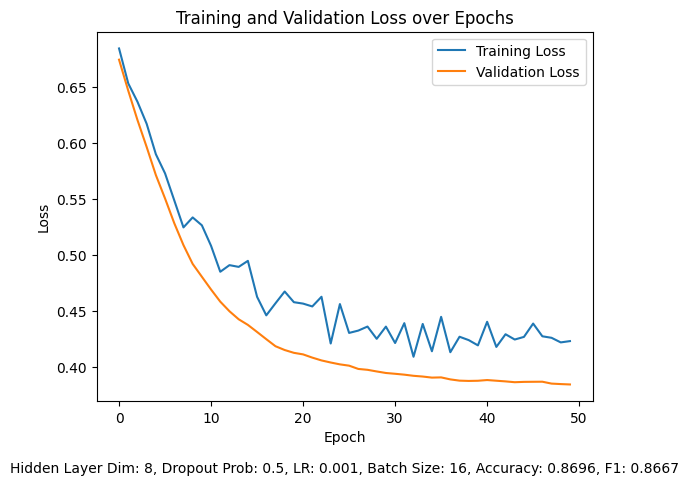

In [52]:
plot_losses(train_losses, val_losses)

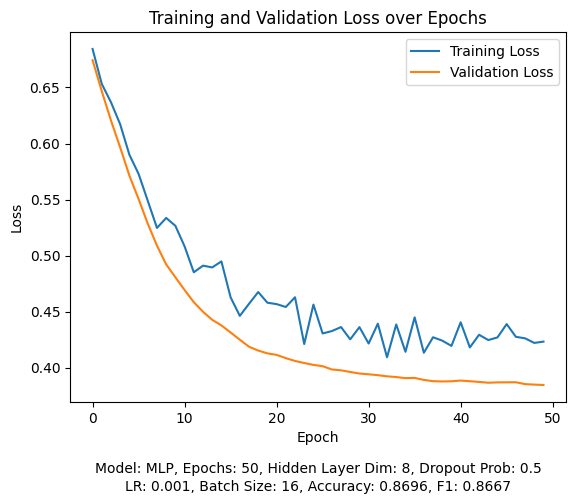

In [66]:
params_s = {
    'epochs': num_epochs,
    'hidden_layer_dim': hidden_layer_dim,
    'batch_size': batch_size,
    'lr': lr,
    'dropout': dropout_prob,
    'accuracy': test_acc,
    'f1': test_f1,
    'model': 'MLP'
}
save_plot_losses(train_losses, val_losses, params_s)


#### <a id='toc1_2_2_5_'></a>[Grid search](#toc0_)

In [68]:

num_epochs_arr= [40,50]
hidden_layer_dim_arr= [8,16,32,64]
batch_size_arr= [8,16,32,64]
lr_arr= [0.001, 0.01, 0.1]


In [70]:
import csv

# Define the path to the CSV file
csv_file = '..//Grid_results//simpleMLP_results_4.csv'

# Open the CSV file in write mode
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(['num_epochs', 'hidden_layer_dim', 'batch_size', 'lr', 'test_accuracy','test_f1','delta_loss'])


    for epoch in num_epochs_arr:
        for hidden_layer_dim in hidden_layer_dim_arr:
            for batch_size in batch_size_arr:
                for lr in lr_arr:
                    print(f'num_epochs: {epoch}, hidden_layer_dim: {hidden_layer_dim}, batch_size: {batch_size}, lr: {lr}')
                    # Create DataLoaders
                    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=generator)
                    #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,generator=generator)

                    # Initialize model, criterion, and optimizer
                    model = SimpleMLP(input_size,hidden_layer_dim, dropout_prob)
                    criterion = nn.BCELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)

                    # Train and evaluate the model
                    train_losses, val_losses = train_model(model, train_loader,val_loader, criterion, optimizer, epoch, printing=False)
                    delta_loss = abs(val_losses[-1] - train_losses[-1])
                    test_acc, test_f1 = evaluate_model(model, test_loader)
                    
                    writer.writerow([epoch, hidden_layer_dim, batch_size, lr, test_acc,test_f1,delta_loss])
                    

num_epochs: 40, hidden_layer_dim: 8, batch_size: 8, lr: 0.001
Test Accuracy: 0.8478
F1 Score: 0.8462
num_epochs: 40, hidden_layer_dim: 8, batch_size: 8, lr: 0.01
Test Accuracy: 0.8804
F1 Score: 0.8830
num_epochs: 40, hidden_layer_dim: 8, batch_size: 8, lr: 0.1
Test Accuracy: 0.8641
F1 Score: 0.8571
num_epochs: 40, hidden_layer_dim: 8, batch_size: 16, lr: 0.001
Test Accuracy: 0.8261
F1 Score: 0.8261
num_epochs: 40, hidden_layer_dim: 8, batch_size: 16, lr: 0.01
Test Accuracy: 0.8750
F1 Score: 0.8770
num_epochs: 40, hidden_layer_dim: 8, batch_size: 16, lr: 0.1
Test Accuracy: 0.8424
F1 Score: 0.8221
num_epochs: 40, hidden_layer_dim: 8, batch_size: 32, lr: 0.001
Test Accuracy: 0.8315
F1 Score: 0.8324
num_epochs: 40, hidden_layer_dim: 8, batch_size: 32, lr: 0.01
Test Accuracy: 0.8804
F1 Score: 0.8830
num_epochs: 40, hidden_layer_dim: 8, batch_size: 32, lr: 0.1
Test Accuracy: 0.8587
F1 Score: 0.8523
num_epochs: 40, hidden_layer_dim: 8, batch_size: 64, lr: 0.001
Test Accuracy: 0.8315
F1 Score:

In [71]:
results = pd.read_csv(csv_file)
max_test_accuracy_row = results.loc[results['test_accuracy'].idxmax()]
print(max_test_accuracy_row)

num_epochs          50.000000
hidden_layer_dim    32.000000
batch_size          16.000000
lr                   0.010000
test_accuracy        0.885870
test_f1              0.886486
delta_loss           0.208176
Name: 76, dtype: float64


In [73]:
results = pd.read_csv(csv_file)
max_test_f1_row = results.loc[results['test_f1'].idxmax()]
print(max_test_f1_row)

num_epochs          50.000000
hidden_layer_dim    32.000000
batch_size          16.000000
lr                   0.010000
test_accuracy        0.885870
test_f1              0.886486
delta_loss           0.208176
Name: 76, dtype: float64


In [72]:
results = pd.read_csv(csv_file)
min_deltaloss_row = results.loc[results['delta_loss'].idxmin()]
print(min_deltaloss_row)

num_epochs          40.000000
hidden_layer_dim     8.000000
batch_size          16.000000
lr                   0.001000
test_accuracy        0.826087
test_f1              0.826087
delta_loss           0.002269
Name: 3, dtype: float64


### <a id='toc1_2_3_'></a>[DeepMLP](#toc0_)

#### <a id='toc1_2_3_1_'></a>[Model](#toc0_)

In [58]:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_layer_dims, dropout_prob=0.5):
        super(DeepMLP, self).__init__()
        
        layers = []
        current_input_size = input_size
        
        for hidden_dim in hidden_layer_dims:
            layers.append(nn.Linear(current_input_size, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            current_input_size = hidden_dim
        
        layers.append(nn.Linear(current_input_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, printing=True):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation loss
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        if printing:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)  # Calculate F1 score
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    return accuracy, f1


#### <a id='toc1_2_3_2_'></a>[Params](#toc0_)

In [130]:
input_size = X.shape[1]
hidden_layer_dims = [32, 16, 16]
batch_size_d = 8
dropout_prob_d = 0.3
lr_d = 0.0001
num_epochs_d = 200


In [131]:
train_loader_d, val_loader_d, test_loader_d = dataLoad(train_dataset, val_dataset, test_dataset, batch_size_d, generator)

In [132]:
# Initialize model, criterion, and optimizer
model_deep = DeepMLP(input_size, hidden_layer_dims, dropout_prob)
criterion_d = nn.BCELoss()
optimizer_d = optim.Adam(model_deep.parameters(), lr=lr_d,weight_decay=1e-4)

# Train and evaluate the model
train_losses_d, val_losses_d = train_model(model_deep, train_loader_d, val_loader_d,criterion_d, optimizer_d, num_epochs_d)
delta_loss_d = abs(val_losses_d[-1] - train_losses_d[-1])
test_acc_d, test_f1_d = evaluate_model(model_deep, test_loader_d)

Epoch 1/200, Loss: 0.7123, Val Loss: 0.7089
Epoch 2/200, Loss: 0.7132, Val Loss: 0.7060
Epoch 3/200, Loss: 0.7067, Val Loss: 0.7036
Epoch 4/200, Loss: 0.7050, Val Loss: 0.7004
Epoch 5/200, Loss: 0.7052, Val Loss: 0.6980
Epoch 6/200, Loss: 0.7011, Val Loss: 0.6955
Epoch 7/200, Loss: 0.6976, Val Loss: 0.6929
Epoch 8/200, Loss: 0.6941, Val Loss: 0.6902
Epoch 9/200, Loss: 0.6975, Val Loss: 0.6880
Epoch 10/200, Loss: 0.6900, Val Loss: 0.6854
Epoch 11/200, Loss: 0.6869, Val Loss: 0.6821
Epoch 12/200, Loss: 0.6812, Val Loss: 0.6790
Epoch 13/200, Loss: 0.6789, Val Loss: 0.6756
Epoch 14/200, Loss: 0.6751, Val Loss: 0.6718
Epoch 15/200, Loss: 0.6809, Val Loss: 0.6681
Epoch 16/200, Loss: 0.6767, Val Loss: 0.6642
Epoch 17/200, Loss: 0.6797, Val Loss: 0.6605
Epoch 18/200, Loss: 0.6704, Val Loss: 0.6558
Epoch 19/200, Loss: 0.6673, Val Loss: 0.6507
Epoch 20/200, Loss: 0.6627, Val Loss: 0.6455
Epoch 21/200, Loss: 0.6596, Val Loss: 0.6399
Epoch 22/200, Loss: 0.6465, Val Loss: 0.6330
Epoch 23/200, Loss:

#### <a id='toc1_2_3_3_'></a>[Plots](#toc0_)

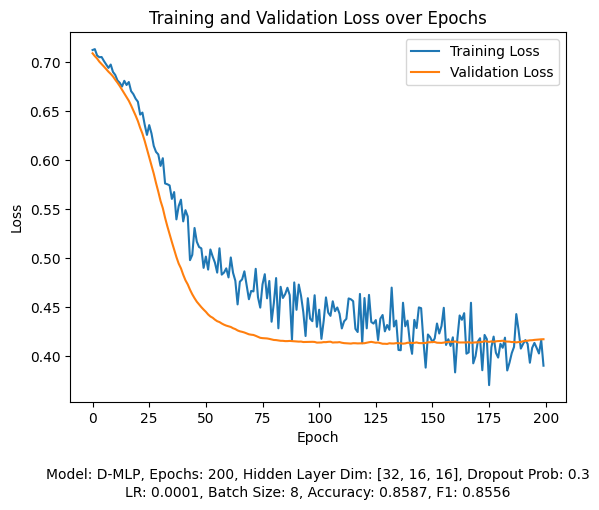

In [133]:
params_d = {
    'epochs': num_epochs_d,
    'hidden_layer_dim': hidden_layer_dims,
    'batch_size': batch_size_d,
    'lr': lr_d,
    'dropout': dropout_prob_d,
    'accuracy': test_acc_d,
    'f1': test_f1_d,
    'model': 'D-MLP'
}
save_plot_losses(train_losses_d, val_losses_d,params_d)